In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# [ IMPORTS ]

In [1]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.signal as scsig

# [ GLOBAL ]

In [2]:
#===========================================================================================================
# DEFINE SOURCE DIRECTORIES
#===========================================================================================================
# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data' #'/home/spooky/ecg/workdir'
print('GLOBAL DIR :: '+global_dir)

#===========================================================================================================
#  following are required for one time npy database building

# >> global MAT directory, contains signal data in matlab (.mat) format
global_matdir = os.path.join(global_dir, 'db_mat') 
print('GLOBAL MAT DIR :: '+global_matdir)

# >> global NPY directory, contains signal and meta data in numpy (.npy) format
global_npydir = os.path.join(global_dir, 'db_npy') 
print('GLOBAL NPY DIR :: '+global_npydir)

# beat and non-beat annotations, signal data types to be used to save data in npy format
g_BEAT_POSTFIX = 'BEAT'         #<<--- beat annotations
g_NBEAT_POSTFIX = 'NBEAT'       #<<--- non-beat annotations
g_RAW_II_POSTFIX = 'RAW_II'     #<<--- Raw lead2 signal from mat file
g_BLF_II_POSTFIX = 'BLF_II'     #<<--- Baseline fitted signal
g_RES_II_POSTFIX = 'RES_II'     #<<--- Resampled to BASIC_SRATE
g_SIG_II_POSTFIX = 'SIG_II'     #<<--- Removed manual gain
#===========================================================================================================

#=================================================
# Auto-Create other working directory
#=================================================
# >> model directory, contains model weights, use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model')
print('GLOBAL MODEL DIR :: ' + global_modeldir)

# >> dataset directory, contains manually generated datasets to be used for experiment
global_dsdir = os.path.join(global_dir, 'db_dataset') 
print('GLOBAL DATASET DIR :: ' + global_dsdir)

# >> temp directory, contains manually generated temporary data to be used for experiments
global_tempdir = os.path.join(global_dir, 'db_temp') 
print('GLOBAL TEMP DIR :: ' + global_tempdir)
#>>----------------------------------------------- 

# >> annotation directory, contains annotation mapping files to be used for experiments
global_antdir = os.path.join(global_dir, 'db_ant') 
print('GLOBAL ANNOTATION DIR :: ' + global_antdir)
#>>----------------------------------------------- 

# Resample every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))

GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL DATASET DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL TEMP DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp
GLOBAL ANNOTATION DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant
Basic sampling rate(Hz): 128


# [ ***_BUILD_NPY_DATABASE_*** ]

This is a one time procedure

In [ ]:
# Create global directory structure
os.makedirs(global_npydir , exist_ok = True)  
os.makedirs(global_modeldir , exist_ok = True) 
os.makedirs(global_dsdir , exist_ok = True) 
os.makedirs(global_tempdir , exist_ok = True) 
os.makedirs(global_antdir , exist_ok = True) 

## [ ***Define Params*** ]

In [ ]:
# select source and destination dirs for data extraction
import shutil
from scipy.io import loadmat
from scipy.signal import medfilt

# === Define ECG Leads============================
# 6 Limb leads
std_I, std_II, std_III, std_AVL, std_AVR, std_AVF = 'I', 'II', 'III', 'AVL', 'AVR', 'AVF'
# 6 lateral leads
std_V1, std_V2, std_V3, std_V4, std_V5, std_V6, = 'V1', 'V2', 'V3', 'V4', 'V5', 'V6' 

# === Define ECG Lead Mapper Dict============================
g_LEAD_MAPPER = {}

# for incartdb
g_LEAD_MAPPER['I']=std_I
g_LEAD_MAPPER['II']=std_II
g_LEAD_MAPPER['III']=std_III
g_LEAD_MAPPER['AVL']=std_AVL
g_LEAD_MAPPER['AVR']=std_AVR
g_LEAD_MAPPER['AVF']=std_AVF
g_LEAD_MAPPER['V1']=std_V1
g_LEAD_MAPPER['V2']=std_V2
g_LEAD_MAPPER['V3']=std_V3
g_LEAD_MAPPER['V4']=std_V4
g_LEAD_MAPPER['V5']=std_V5
g_LEAD_MAPPER['V6']=std_V6

# for mitdb
g_LEAD_MAPPER['MLII']=std_II
g_LEAD_MAPPER['V5']=std_V5  #<----duplicate

# for svdb
g_LEAD_MAPPER['ECG1']=std_II
g_LEAD_MAPPER['ECG2']=std_V5 #<------------- gotta be sure about this

# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

# === For Identifing Valid annotations and seperating beat/non-beat annotations====
global_annot = os.path.join(global_dir, 'annotations.txt') 
print('ANNOTATIONS MAPPER:: '+ global_annot)
g_ant_map_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_ant_map={}
beat_indicator = 'b'
non_beat_indicator = 'n'
for a in g_ant_map_data:
    # a[0] =  # orignal pysionet label (char)
    # a[1] =  # beat/non-beat indicator (char)
    # a[2]  = # description (str)
    g_ant_map[a[0]]= a[1]
    print("'"+a[0]+'\t'+a[1]+'\t'+a[2])
g_ant_map_keys = g_ant_map.keys()

def get_ants_logger():  #<<--- this will be used to import data to excel sheet
    ants_logger = {}    #<<--- for counting total labels per record
    for i in g_ant_map_keys:
        ants_logger[i] = 0
    return ants_logger


ANNOTATIONS MAPPER:: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt
'N	b	Normal beat
'L	b	Left bundle branch block beat
'R	b	Right bundle branch block beat
'B	b	Bundle branch block beat (unspecified)
'A	b	Atrial premature beat
'a	b	Aberrated atrial premature beat
'J	b	Nodal (junctional) premature beat
'S	b	Supraventricular premature or ectopic beat (atrial or nodal)
'V	b	Premature ventricular contraction
'r	b	R-on-T premature ventricular contraction
'F	b	Fusion of ventricular and normal beat
'e	b	Atrial escape beat
'j	b	Nodal (junctional) escape beat
'n	b	Supraventricular escape beat (atrial or nodal)
'E	b	Ventricular escape beat
'/	b	Paced beat
'f	b	Fusion of paced and normal beat
'Q	b	Unclassifiable 
'?	b	Beat not classified during learning
'[	n	Start of ventricular flutter/fibrillation
'!	n	Ventricular flutter wave
']	n	End of ventricular flutter/fibrillation
'x	n	Non-conducted P-wave (blocked APC)
'(	n	Waveform onset
')	n	Waveform end
'p	n	Peak of P-wave
't	n	Peak

## [ ***~Build Database*** ]

In [ ]:
build_db_dict = {'mitdb':{},'svdb':{},'incartdb':{}} ##<--- for purpose of recording annotation count
build_db_list = build_db_dict.keys()
# === START PROCEDURE ===========================
timestamp_start = datetime.datetime.now()

for build_db_name in build_db_list:
    # check source mat sub-directory

    print('Working ',build_db_name)
    db_matdir = os.path.join(global_matdir, build_db_name + '_mat') 
    if not os.path.exists(db_matdir):
        print('ERROR: mat directory does not exsist. cannot proceed.')
        print('Not Found : '+ str(db_matdir))
    else:
        # mat sub-directory exists, proceed to preapare data
        print('DB_MAT DIR :: '+db_matdir)

        # prepare destination npy sub-directory
        db_npydir = os.path.join(global_npydir, build_db_name + '_npy') 
        os.makedirs(db_npydir , exist_ok = True) 
        print('DB_NPY DIR :: '+db_npydir)

        # place a copy of records file in dataset dir
        record_file_path = os.path.join(db_matdir,'RECORDS')
        shutil.copy2(record_file_path, db_npydir)

        # load record list
        reclist = np.loadtxt(record_file_path, dtype='str',delimiter="\n")
        xs=len(reclist)
        print('Records['+str(xs)+ ']::'+str(reclist))

        
        #------------------------------------------------------------------------------------------------
        # Build Annotations
        #------------------------------------------------------------------------------------------------
        print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records in '+build_db_name)
        print('REC\tFound\tBEAT\tNONB' )
        for rec in reclist:

            # prepare ant_logger to recording annotation count
            build_db_dict[build_db_name][rec] = get_ants_logger()

            ants = np.loadtxt(os.path.join(db_matdir , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
            antsbeat = np.zeros((0,2),dtype='str')
            antsnonbeat = np.zeros((0,2),dtype='str')
            for i in range(0,len(ants)):
                a_a = ants[i].split()
                a_sample = a_a[1]
                a_label = a_a[2] 
                if a_label in g_ant_map_keys:
                    build_db_dict[build_db_name][rec][a_label]+=1   #<<-increment by one, key should already exist
                    beat_type = g_ant_map[a_label]
                    if beat_type == beat_indicator: # is beat annot
                        antsbeat = np.vstack((antsbeat,np.array([a_sample,a_label]))) # sample,label str
                    else: # is non beat
                        antsnonbeat = np.vstack((antsnonbeat,np.array([a_sample,a_label]))) # sample,label str
                else:
                    print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file '+ rec +'a.txt, skipping....')
            
            print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsbeat))+'\t' + str(len(antsnonbeat) ))
            # save for this record
            np.save(os.path.join(db_npydir , rec+ '_'+g_BEAT_POSTFIX+'.npy'), antsbeat)
            np.save(os.path.join(db_npydir , rec+ '_'+g_NBEAT_POSTFIX+'.npy'), antsnonbeat)

        print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')

        #------------------------------------------------------------------------------------------------
        # Process Signal Data
        #-----------------------------------------------------------------------------------------------
        
        xc=0
        print('\nBEGIN TASK :: Processing signal data for ' + str(xs)+ ' records in '+build_db_name+'\n')
        for rec in reclist:
            xc+=1
            rst = str(xc)+'/'+str(xs)+' REC: '+str(rec)
            #print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))

            # first read header file
            #print('  Reading header file... ')
            minfo_path = os.path.join(db_matdir,rec+'m.hea')
            f = open(minfo_path,'r')
            info = f.readlines()
            f.close()

            zero_line = info[0].split() # rec, noslead, srate, len_in_samples
            nos_leads = int( zero_line[1] ) #tottal number of leads available
            srate = int( zero_line[2] ) #sampling rate
            dlen = int( zero_line[3] ) # total sampling points, data length
            duration = dlen/srate # total duration in seconds
            rst+= '::'+ str(zero_line)+'::'
            lead_info = {}
            for i in range(1, nos_leads+1):
                tIA = info[i].split()   # this should have 9 values      I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
                #t_rec = tIA[0]         # record name:                   'I67m.mat'
                #t_wbit = tIA[1]        # written at and offset bits:    '16+192'
                t_gain = tIA[2]        # gain (amplitude resolution):   '623/mV'
                #t_adcr = tIA[3]        # ADC amplitude resolution:      '16'
                #t_base = tIA[4]        # baseline:                      '0'
                #t_fval = tIA[5]        # first_value:                   '4441'
                #t_chk = tIA[6]         # checksum:                      '1894'
                #t_blk = tIA[7]         # block_size:                    '0'
                t_lead = tIA[8]        # lead name:                      'II'

                if t_lead in g_LEAD_MAPPER.keys():
                    tIL = g_LEAD_MAPPER[t_lead]
                    lead_info[tIL] = [ int(i-1) ,int(t_gain.split('/')[0]) ]
                    # lead_type :: { [lead_index, manual_gain ] }
                else:
                    rst+='\n\tWARNING:: UNMAPPED LEAD '+ str(t_lead)+'\n'
            
            if std_II in lead_info.keys():
                
                # saving raw lead2 signal
                L2_index = lead_info[std_II][0]
                rst+=' Lead_II:: ' +  info[L2_index+1] 
                mat_signal = loadmat(os.path.join( db_matdir , rec + 'm.mat'))['val'][L2_index]
                np.save(os.path.join(db_npydir , rec + '_'+g_RAW_II_POSTFIX+'.npy'), mat_signal ) 
                
                # baseline fitting by filtering
                for i in range(0, len(ms_flt_array)):
                    mfa[i] = get_median_filter_width(srate,ms_flt_array[i])
                blf_signal = filter_signal(mat_signal, mfa)
                np.save(os.path.join(db_npydir , rec + '_'+g_BLF_II_POSTFIX+'.npy'), blf_signal ) 

                # Resampling blf signal
                sr_ratio = BASIC_SRATE/srate
                res_signal = scsig.resample(blf_signal, round(len(blf_signal)*sr_ratio))
                np.save(os.path.join(db_npydir , rec + '_'+g_RES_II_POSTFIX+'.npy'), res_signal ) 

                # Remove manual gain
                L2_gain = lead_info[std_II][1]
                sig_signal = res_signal/L2_gain
                np.save(os.path.join(db_npydir , rec + '_'+g_SIG_II_POSTFIX+'.npy'), sig_signal ) 

            else:
                rst+= ' Lead II:: data type not found for record ' + str( rec ) + '\n'
            print(rst)
        print('\nEND TASK :: Processing signal data for ' + str(xs)+ ' records')

#---------------------------------------------------------------------------------------------------------------------------------------------
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Working  mitdb
DB_MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/mitdb_mat
DB_NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
Records[48]::['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '200'
 '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214' '215'
 '217' '219' '220' '221' '222' '223' '228' '230' '231' '232' '233' '234']

BEGIN TASK :: Build annotations for 48 records in mitdb
REC	Found	BEAT	NONB
100	2274	2273	1
101	1874	1865	9
102	2192	2187	5
103	2091	2084	7
104	2311	2229	82
105	2691	2572	119
106	2098	2027	71
107	2140	2137	3
108	1824	1763	61
109	2535	2532	3
111	2133	2124	9
112	2550	2539	11
113	1796	1795	1
114	1890	1879	11
115	1962	1953	9
116	2421	2412	9
117	1539	1535	4
118	2301	2278	23
119	2094	1987	107
121	1876	1863	13
122	2479	2476	3
123	1519	1518	1
124	1634	1619	15
200	2792	2601	191
201	2039	1963	76
202	2146	2136	10
203	3108	2

## [ ***Print build_db_dict*** ]

In [ ]:
ord_ants = list(g_ant_map_keys)
heading = 'ECG_DB\tREC'
for ilabel in range(0,len(ord_ants)):
    heading += "\t'"+ord_ants[ilabel]
print(heading)

body = ''
for idb in build_db_dict.keys():
    for irec in build_db_dict[idb]:
        body=idb+'\t'+irec
        ants_log = build_db_dict[idb][irec]
        for ilabel in range(0,len(ord_ants)):
            body+='\t'+str(ants_log[ord_ants[ilabel]])
        print(body)

ECG_DB	REC	'N	'L	'R	'B	'A	'a	'J	'S	'V	'r	'F	'e	'j	'n	'E	'/	'f	'Q	'?	'[	'!	']	'x	'(	')	'p	't	'u	'`	''	'^	'|	'~	'+	's	'T	'*	'D	'=	'"	'@
mitdb	100	2239	0	0	0	33	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0
mitdb	101	1860	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	4	4	1	0	0	0	0	0	0	0
mitdb	102	99	0	0	0	0	0	0	0	4	0	0	0	0	0	0	2028	56	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0
mitdb	103	2082	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	6	1	0	0	0	0	0	0	0
mitdb	104	163	0	0	0	0	0	0	0	2	0	0	0	0	0	0	1380	666	18	0	0	0	0	0	0	0	0	0	0	0	0	0	0	37	45	0	0	0	0	0	0	0
mitdb	105	2526	0	0	0	0	0	0	0	41	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	0	0	0	0	0	30	88	1	0	0	0	0	0	0	0
mitdb	106	1507	0	0	0	0	0	0	0	520	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	30	41	0	0	0	0	0	0	0
mitdb	107	0	0	0	0	0	0	0	0	59	0	0	0	0	0	0	2078	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	1	0	0	0	0	0	0	0
mitdb	108	1739	0	0	0	4	0	0	0	17	0	2	0	1	0	0	0	0	0	0	0	0	0	11	0	0	0	0	0	0	0	0	8	41	1	0	0	

# [ CLASS_DEFS ]

In [3]:
#Class Definitions
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  exclude_recs, tag_recs, sampling_rate):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #float or int
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_npy,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_recs)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.recs_tag = set(tag_recs)
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'SAMPLING RATE :: '+ str(self.srate))
        print( 'DATA DIR :: ' + self.dir_npy )
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self, recset):
        rec = random.choice(list(recset))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
g_SUPRESS_DATA_WARNING=False
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name
        if recname in db.recs_all:
            if recname in db.recs_exc:
                print('WARNING:: Record "'+ recname +'" is marked excluded from database '+ db.name )
        else:
            print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )
        self.data_npy = {}                          # dict dict of data file content used in self.read_data_npy('key')
        self.data_temp = {}                          # dict dict of data file content used in self.read_data_temp('key')
        self.binfo = None                           # class binfo       

##<------------------------------------------------- get instance of binfo class
    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo

    def refresh_binfo(self):
        self.binfo = ecg_binfo(self)
        return self.binfo

##<------------------------------------------------- data reading for npydir
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_npy[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data(self, data_type):
        if data_type in self.data_npy.keys():
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

##<------------------------------------------------- for tempdir
    def load_data_temp(self, data_type, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_temp[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data_temp(self, data_type, dir_path):
        if data_type in self.data_temp.keys():
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data_temp(data_type, dir_path)

    def save_data_temp(self, data_type, data_array, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def del_data_temp(self, data_type, dir_path, vb):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            if vb:
                print('Removing: '+str(ipath))
            os.remove(ipath)
            return 1
        else:
            return 0
#------------------------------------------------------------------------------------------------

class ecg_binfo:
    def __init__(self, rec):
         
        # the record object
        self.rec = rec
        
        # calulate ratio for converting peak locations to basic_sampling_rate
        self.sr_ratio = BASIC_SRATE/self.rec.db.srate
        
        # read orignal annotations
        r_peaks_ants = rec.read_data(g_BEAT_POSTFIX)       # orignal ant file [ *  '625310' 'N' * ] 
        
        # calculate count of R peaks (excluding first and last)
        self.rp_count = len(r_peaks_ants) - 2
        
        # Extract Location and Labels of Peaks (exclude first and last beat)
        r_peaks_int_raw = r_peaks_ants[:,0].astype('int')
        r_peaks_int = np.round(r_peaks_int_raw * self.sr_ratio).astype('int')
        r_ants_str = r_peaks_ants[:,1]
        
        # Location
        self.rp_raw = r_peaks_int_raw[1:-1]
        self.rp_curr = r_peaks_int[1:-1]    # current R peak
        self.rp_prev = r_peaks_int[0:-2]    # previous R peak (in samples)
        self.rp_next = r_peaks_int[2:]      # next R peak (in samples)
        
        # Label
        self.rl_curr = r_ants_str[1:-1]
        self.rl_prev = r_ants_str[0:-2]
        self.rl_next = r_ants_str[2:]
 
        # calculate temporal info
        self.rp_sec = self.rp_curr / BASIC_SRATE                 # peak location (in sec)
        self.rri_prev = (self.rp_curr - self.rp_prev) / BASIC_SRATE   # prev RRI (in sec) 
        self.rri_next = (self.rp_next - self.rp_curr) / BASIC_SRATE   # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)              # difference b/w prev and next RRI (in sec) 
        self.rri_dur = (self.rri_next + self.rri_prev)                # total duration from prev to next R-peak
        

    def get_signal_data_var(self, ith_peak): # data_type = g_SIG_II_POSTFIX
        # prev peak to next peak
        sel_sig = self.rec.read_data(g_SIG_II_POSTFIX) 
        ff = self.rp_prev[ith_peak]
        tt = self.rp_next[ith_peak]
        pp = self.rp_curr[ith_peak]
        return sel_sig[ff:tt+1], (pp-ff) #<- also return position of peak
    
    def get_signal_data_fix(self, ith_peak, v_left_sec, v_right_sec): # data_type = g_SIG_II_POSTFIX
        sel_sig = self.rec.read_data(g_SIG_II_POSTFIX) 
        ff = self.rp_curr[ith_peak]-int(v_left_sec*BASIC_SRATE)
        tt = self.rp_curr[ith_peak]+int(v_right_sec*BASIC_SRATE)
        pp = self.rp_curr[ith_peak]
        return sel_sig[ff:tt+1], (pp-ff) #<- also return position of peak
    
    def map_ants2int(self,map_function):
         self.rli_curr = map_function(self.rl_curr)
         self.rli_prev = map_function(self.rl_prev)
         self.rli_next = map_function(self.rl_next)
#-----------------------------------------------------------------------------------------------


# [ SELECT ANT MAPPER ] 

In [ ]:
ls_ants = os.listdir(global_antdir)
print('Available annotation files ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

Available annotation files [4]
default_map.txt
default_labels.txt
nsvf_map.txt
nsvf_labels.txt
--------------------------


## [ *mapping_labels* ]

In [4]:
# standard labels and mappings
sel_labels = os.path.join(global_antdir, 'default_labels.txt') 
sel_map = os.path.join(global_antdir, 'default_map.txt') 

# ------ load standard labels ------------------------------------------
sel_labels_data = np.loadtxt(sel_labels, dtype='str',delimiter="\t")
g_STD_LABELS={}
print('\nStandard Labels::')
for a in sel_labels_data:
    # a[0] =  # standard label (char)
    # a[1] =  # mapped color (str)
    # a[2]  = # description (str)
    g_STD_LABELS[a[0]]= a[1]
    print(a[0]+'\t'+a[1]+'\t'+a[2])
#g_LABELS = np.array(list(g_STD_LABELS.keys()))
# ------ load mapping data ------------------------------------------
ant_map_data = np.loadtxt(sel_map, dtype='str',delimiter="\t")
g_STD_NO_MAP = '_'
g_STD_MAP={}
print('\nMapping::')
for a in ant_map_data:
    # a[0] =  # orignal pysionet label (char)
    # a[1] =  # mapped standard label (char)
    # a[2]  = # description (str)
    g_STD_MAP[a[0]]= a[1] ##<<----------------mapping dictionary
    print(a[0]+'\t'+a[1]+'\t'+a[2])
print('\n',g_STD_MAP.keys())

# define array mapping function --------------------------------------
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='str')     # should be single char
    for i in range(0, len(peak_label)):
        res[i] = g_STD_MAP[peak_label[i]]
    return res

#g_LABELS = g_LABELS_MAP[:,0]
#g_COLOR = g_LABELS_MAP[:,1]
# T10 categorical palette
# ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
# 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
# 'tab:olive', 'tab:cyan']
#print(len(g_LABELS_MAP))
#print(g_LABELS_MAP)



Standard Labels::
N	tab:green	Normal
B	tab:brown	Bundle Branch Block
S	tab:red	Supraventricular Premature
V	tab:blue	Ventricular Premature
F	tab:olive	Fusion
E	tab:orange	Escape
P	tab:purple	Paced
Q	tab:gray	Unclassified

Mapping::
N	N	Normal beat
L	B	Left bundle branch block beat
R	B	Right bundle branch block beat
B	B	Bundle branch block beat (unspecified)
A	S	Atrial premature beat
a	S	Aberrated atrial premature beat
J	S	Nodal (junctional) premature beat
S	S	Supraventricular premature or ectopic beat (atrial or nodal)
V	V	Premature ventricular contraction
r	V	R-on-T premature ventricular contraction
F	F	Fusion of ventricular and normal beat
e	E	Atrial escape beat
j	E	Nodal (junctional) escape beat
n	E	Supraventricular escape beat (atrial or nodal)
E	E	Ventricular escape beat
/	P	Paced beat
f	P	Fusion of paced and normal beat
Q	Q	Unclassifiable 
?	Q	Beat not classified during learning
[	_	Start of ventricular flutter/fibrillation
!	_	Ventricular flutter wave
]	_	End of ventricular flu

# [ BUILD_ALL_DB ]

In [5]:
print('Buidling all_db')
all_db = {}
#------------------------------------------------------------------------
mitdb_ex = []
mitdb_tags = []
all_db['mitdb'] = ecg_db('mitdb',  mitdb_ex, mitdb_tags, 360)
#------------------------------------------------------------------------
svdb_ex = []
svdb_tags = []
all_db['svdb'] = ecg_db('svdb',  svdb_ex, svdb_tags, 128)
#------------------------------------------------------------------------
incartdb_ex = []
incartdb_tags = []
all_db['incartdb'] = ecg_db('incartdb', incartdb_ex, incartdb_tags, 257)
#------------------------------------------------------------------------
print('')
print(all_db.keys())


Buidling all_db

Initailze new ecg database ... 
DB NAME :: mitdb
SAMPLING RATE :: 360
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
RECORD SET :: [48] {'203', '232', '119', '114', '234', '108', '215', '112', '222', '118', '111', '117', '223', '116', '109', '107', '209', '103', '202', '228', '219', '121', '217', '210', '213', '221', '207', '104', '208', '233', '102', '231', '113', '220', '101', '105', '115', '106', '201', '230', '205', '123', '124', '212', '100', '214', '200', '122'}

Initailze new ecg database ... 
DB NAME :: svdb
SAMPLING RATE :: 128
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
RECORD SET :: [78] {'843', '879', '864', '884', '878', '886', '861', '850', '828', '891', '893', '892', '851', '806', '860', '844', '808', '868', '803', '883', '807', '880', '821', '841', '877', '829', '887', '845', '827', '867', '869', '854', '825', '820', '856', '826', '857', '822', '852', '846', '875', '847', '810', '872', '885

# [ VIEW_DATA ]

In [6]:
# select a database and a record within it
#-----------------------------------------
idb = 'mitdb'
irec = '210'
#-----------------------------------------
sel_db = all_db[idb]
sel_rec = sel_db.get_record(irec)
print(sel_rec.name)
#-----------------------------------------

mitdb_210


## [ Load Binfo and Signal ]

In [7]:
#-----------------------------------------
# load beat info 
sel_binfo = sel_rec.read_binfo()
sel_binfo.map_ants2int(mapstd)
print('Total beats = '+ str(sel_binfo.rp_count))
#-----------------------------------------

#-----------------------------------------
# seperate out beats
sel_btypes = {}
xsum = 0
print('Type of beats')
for i in g_STD_LABELS.keys():
    sel_btypes[i] = np.where(sel_binfo.rli_curr==i)[0]
    print(str(i)+'\t'+str(len(sel_btypes[i])))
    xsum+=len(sel_btypes[i])
print('____\t'+str(xsum))
sel_btypes[g_STD_NO_MAP] = np.where(sel_binfo.rli_curr==g_STD_NO_MAP)[0]
print('_\t'+str(len(sel_btypes[g_STD_NO_MAP])))
#-----------------------------------------

#-----------------------------------------
# load signal
sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
print('Total signal length @ ' + str(BASIC_SRATE) + 'Hz = ' + str(sel_sig.shape))
#-----------------------------------------


Total beats = 2648
Type of beats
N	2421
B	0
S	22
V	194
F	10
E	1
P	0
Q	0
____	2648
_	0
Total signal length @ 128Hz = (231111,)


## [ *Compare Signal* ]

In [ ]:
# compare with other signal data_types

# load other signal
sel_raw = sel_rec.read_data(g_RAW_II_POSTFIX)
sel_blf = sel_rec.read_data(g_BLF_II_POSTFIX)
sel_res = sel_rec.read_data(g_RES_II_POSTFIX)
sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)

print('RAW signal length @ ' + str(sel_db.srate) + 'Hz = ' + str(sel_raw.shape))
print('BLF signal length @ ' + str(sel_db.srate) + 'Hz = ' + str(sel_blf.shape))
print('RES signal length @ ' + str(BASIC_SRATE) + 'Hz = ' + str(sel_res.shape))
print('SIG signal length @ ' + str(BASIC_SRATE) + 'Hz = ' + str(sel_sig.shape))

sel_binfo = sel_rec.read_binfo()
print('Total beats = '+ str(sel_binfo.rp_count))

RAW signal length @ 360Hz = (650000,)
BLF signal length @ 360Hz = (650000,)
RES signal length @ 128Hz = (231111,)
SIG signal length @ 128Hz = (231111,)
Total beats = 2260


### [ *Plot_All_Signals* ]

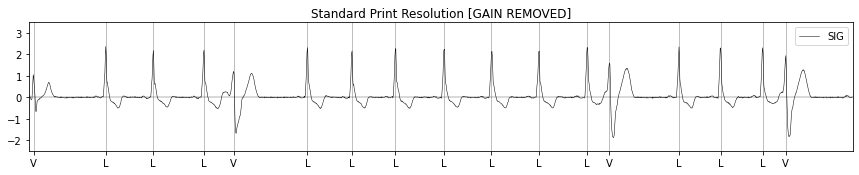

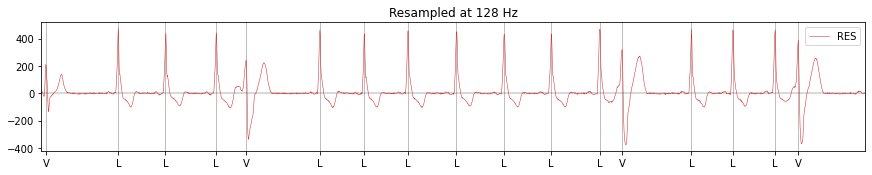

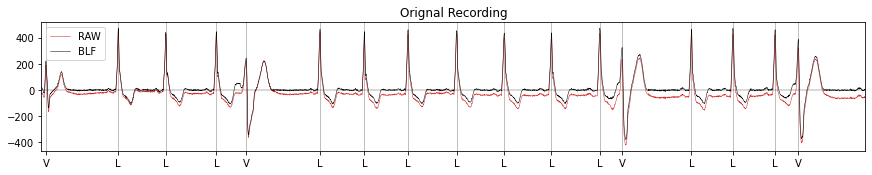

In [ ]:
# plot signal segments
#<<---------------------------------------------Select ECG Segment
fsec = 900
tsec = fsec+(15)
dsec = tsec - fsec
#<<--------------------------------------------------------------------
#<<---------------------------------------------Select Paper Resolution
x_scale = 25 * 0.0393701 # mm/sec -> inches/sec
y_scale = 10 * 0.0393701 # mm/mV -> inches/sec
y_low = -2.5
y_high = 3.5
#<<--------------------------------------------------------------------

if len(sel_sig)==0:
    print('WARNING::Signal was not loaded.')
else:
    ff = fsec * BASIC_SRATE
    tt = tsec * BASIC_SRATE
    dd = tt - ff
    bps_sig = sel_sig[ff:tt]
    bps_res = sel_res[ff:tt]


    ffo = fsec * sel_db.srate
    tto = tsec * sel_db.srate
    ddo = tto - ffo
    bps_raw = sel_raw[ffo:tto]
    bps_blf = sel_blf[ffo:tto]

    lim_query = (sel_binfo.rp_sec >= fsec) & (sel_binfo.rp_sec < tsec)

    dticks = sel_binfo.rp_curr[lim_query]
    dticks_org = sel_binfo.rp_raw[lim_query]
    dlabels = sel_binfo.rl_curr[lim_query]

    dticks_res = dticks - ff
    dticks_raw = dticks_org - ffo


    #<<---------------------------------------------------------------------- Resampled figure No gain
    plt.figure(0, figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
    plt.title('Standard Print Resolution [GAIN REMOVED]')
    plt.xlim(0, len(bps_sig))
    plt.ylim(y_low,y_high)
    plt.xticks(dticks_res,dlabels)
    plt.grid(axis='x')
    plt.plot(bps_sig, linewidth=0.5, color='black',label = 'SIG')
    #plt.plot(bps_res, linewidth=0.5, color='tab:red',label = 'RES')
    plt.hlines(0,0,len(bps_sig), linewidth=0.3)
    plt.legend()
    #<<---------------------------------------------------------------------- Resampled figure
    plt.figure(1, figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
    plt.title('Resampled at '+ str(BASIC_SRATE) + ' Hz')
    plt.xlim(0, len(bps_sig))
    #plt.ylim(y_low,y_high)
    plt.xticks(dticks_res,dlabels)
    plt.grid(axis='x')
    #plt.plot(bps_sig, linewidth=0.5, color='black',label = 'SIG')
    plt.plot(bps_res, linewidth=0.5, color='tab:red',label = 'RES')
    plt.hlines(0,0,len(bps_sig), linewidth=0.3)
    plt.legend()
    #<<---------------------------------------------------------------------- Raw figure
    plt.figure(2, figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
    plt.title('Orignal Recording')
    plt.xlim(0, len(bps_raw))
    #plt.ylim(y_low,y_high)
    plt.xticks(dticks_raw,dlabels)
    plt.grid(axis='x')
    plt.plot(bps_raw, linewidth=0.5, color='tab:red',label = 'RAW')
    plt.plot(bps_blf, linewidth=0.5, color='black', label = 'BLF')
    plt.hlines(0,0,len(bps_raw), linewidth=0.3)
    plt.legend()


## [ Peak-2-Timestamp ]

In [ ]:
# what is the time stamp for ith R-peak
ith_rpeak = 1417

tstamp = sel_binfo.rp_sec[ith_rpeak]
print(tstamp)

1131.9921875


## [ ~Define plotter functions ]

In [8]:
def plot_ecg_rri_dur(signal_info):
     sel_xrange = np.arange(0,signal_info.rp_count)
     plt.figure('duration & rri', figsize=(signal_info.rp_count/10,10)) #,dpi=200
     plt.ylim(-0.5,3.5)
     plt.xlim(-1,signal_info.rp_count+1)
     
     # plot RRI Duration
     plt.plot(signal_info.rri_dur,linewidth = 0.5 ,color='black')
     plt.scatter(sel_xrange,signal_info.rri_dur, label='duration', marker='.',color='black')
     
     # plot RRI Delta
     plt.plot(np.absolute(signal_info.rri_delta),linewidth = 0.5,color='red' )
     plt.scatter(sel_xrange,np.absolute(signal_info.rri_delta), label='delta', marker='.',color='red')
     
     # plot baseline
     plt.hlines(0,0,signal_info.rp_count, linewidth=0.3)
     
     # plot labels
     plt.scatter(sel_btypes[g_STD_NO_MAP],np.zeros(len(sel_btypes[g_STD_NO_MAP]))-0.25,  marker='.', color='black', label='unknown #'+str(len(sel_btypes[g_STD_NO_MAP])))
     for i in g_STD_LABELS.keys():
         plt.scatter(sel_btypes[i],np.zeros(len(sel_btypes[i]))-0.25,  marker='s', color=g_STD_LABELS[i], label=i+' #'+str(len(sel_btypes[i])))
     
     # plot legend
     #plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
     plt.legend()
     
     plt.tight_layout()
     plt.show()

def plot_ecg_rri(signal_info):
     sel_xrange = np.arange(0,signal_info.rp_count)
     plt.figure('rri', figsize=(signal_info.rp_count/10,10)) #,dpi=200
     plt.ylim(-0.5,3.5)
     plt.xlim(-1,signal_info.rp_count+1)
     
     # plot RRI Duration
     plt.plot(signal_info.rri_prev,linewidth = 0.5 ,color='tab:blue')
     plt.scatter(sel_xrange,signal_info.rri_prev, label='rr_interval', marker='.',color='tab:blue')
     
     
     # plot baseline
     plt.hlines(0,0,signal_info.rp_count, linewidth=0.3)
     
     # plot labels
     plt.scatter(sel_btypes[g_STD_NO_MAP],np.zeros(len(sel_btypes[g_STD_NO_MAP]))-0.25,  marker='.', color='black', label='unknown #'+str(len(sel_btypes[g_STD_NO_MAP])))
     for i in g_STD_LABELS.keys():
         plt.scatter(sel_btypes[i],np.zeros(len(sel_btypes[i]))-0.25,  marker='s', color=g_STD_LABELS[i], label=i+' #'+str(len(sel_btypes[i])))
     
     # plot legend
     #plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
     plt.legend()
     
     plt.tight_layout()
     plt.show()

def plot_ecg_segment(signal_info, signal_array, fsec, tsec, x_scale, y_scale, y_low, y_high, mticks_pos, show_rris):
    # plot signal segments
    #<<---------------------------------------------Select ECG Segment
    dsec = tsec - fsec
    print(signal_info.rec.name)
    if len(signal_array)==0:
        print('WARNING::Signal was not loaded.')
        return 0
    else:
        ff = int(fsec * BASIC_SRATE)
        tt = int(tsec * BASIC_SRATE)
        dd = tt - ff

        bps = signal_array[ff:tt]   # signal data

        lim_query = np.where((signal_info.rp_sec >= fsec) & (signal_info.rp_sec < tsec))[0]

        dticks = signal_info.rp_curr[lim_query]-ff  # tick position
        nos_ticks = len(dticks)

        dlabels = signal_info.rl_curr[lim_query]    # orignal labels
        dilabels = signal_info.rli_curr[lim_query]  # mapped labels
        
        dicolors = np.zeros(nos_ticks, dtype='U15') # get color repesentation
        for i in range(0,nos_ticks):
            dicolors[i]= g_STD_LABELS[dilabels[i]]

        print('Time Interval{'+str(dsec)+'s}:['+str(fsec)+':'+str(tsec)+']')
        if nos_ticks > 0:
            print('Beat Interval{'+str(nos_ticks)+'#}:['+str(lim_query[0])+':'+str(lim_query[-1])+']')
        else:
            print('Beat Interval{'+str(nos_ticks)+'#}')

        # prepare figure: signal
        plt.figure('ecg signal', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(y_low,y_high)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
        #plt.xticks(x_grid)
        plt.grid(axis='x')
        # plot signal and baseline
        plt.plot(bps, linewidth=0.5, color='black')
        plt.hlines(0,0,len(bps), linewidth=0.3)
        # plot mapped labels
        plt.scatter(dticks,np.zeros(nos_ticks)+mticks_pos,marker='s',color=dicolors)
        # finalize
        plt.tight_layout()
        plt.show()
        if show_rris:
            ddur = signal_info.rri_dur[lim_query]       # duration
            ddel = np.absolute(signal_info.rri_delta[lim_query] )      # delta rri
            # prepare figure: rri,delta rri
            my_low, my_high = -0.1, 3.5
            plt.figure('ecg meta', figsize = (dsec*x_scale ,(my_high-my_low) * 1.5*y_scale) )
            plt.xlim(0, len(bps))
            plt.ylim(my_low,my_high)
            plt.yticks([])
            plt.xticks(dticks,dlabels)
            #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
            #plt.xticks(x_grid)
            plt.grid(axis='x')

            # plot grid and baseline
            plt.hlines(0,0,len(bps), linewidth=0.3,color='red')
            #for j in [0.5,1,1.5,2,2.5,3]:
            #    plt.hlines(j,0,len(bps), linewidth=0.3,color='black')

            # plot mapped labels
            plt.scatter(dticks,ddur,marker='s',color=dicolors)
            plt.scatter(dticks,ddel,marker='o',color='tab:red')
            plt.plot(dticks,ddur,color='black',linewidth=0.5,linestyle='dotted')
            plt.plot(dticks,ddel,color='black',linewidth=0.5,linestyle='dotted')
            # finalize
            plt.tight_layout()
            plt.show()

        return 1

## [ Plot_RRI_&_Duration ]

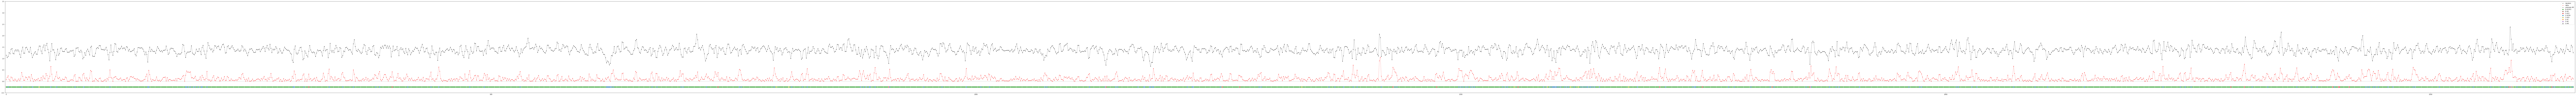

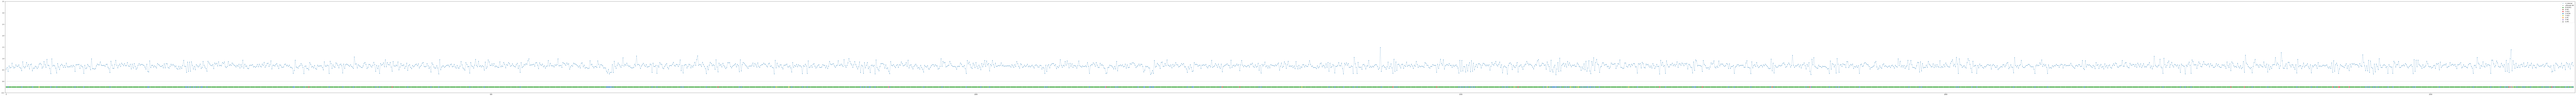

In [9]:
plot_ecg_rri_dur(sel_binfo)
plot_ecg_rri(sel_binfo)

## [ Plot_ECG_Signal ]

mitdb_210
Time Interval{10s}:[300:310]
Beat Interval{15#}:[445:459]


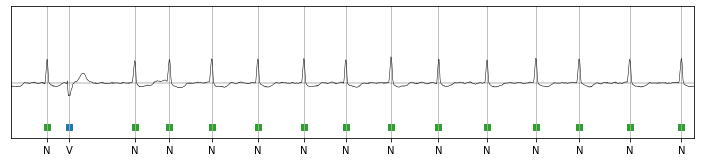

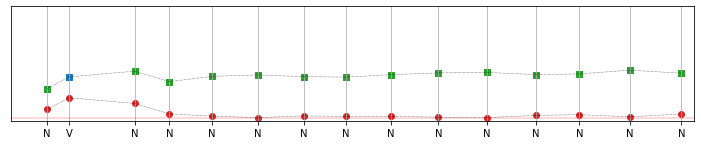

1

In [10]:
fsec = 300
tsec = fsec+10
#<<--------------------------------------------------------------------
#<<---------------------------------------------Select Paper Resolution
#<<--------------------------------------------------------------------
x_scale = 25 * 0.0393701 # mm/sec -> inches/sec
y_scale = 10 * 0.0393701 # mm/mV -> inches/sec
y_low = -2.5
y_high = 3.5
#<<--------------------------------------------------------------------
plot_ecg_segment(sel_binfo, sel_sig, fsec, tsec, x_scale, y_scale, y_low, y_high,-2, True)
#<<--------------------------------------------------------------------

## [ Plot_Single_Beats ]

Select Beats Index to be plotted

In [ ]:
bi = random.randint(0, sel_binfo.rp_count-1)    # option 1 : Select randomly from all beat types

In [ ]:
bi = 1730                                           # option 2 : select manually by specifiying index

In [ ]:
bi =  np.random.choice(sel_btypes['N'], size=1)[0]    # option 3: Select randomly from a type of beat

In [ ]:
bi =  sel_btypes['N'][300]                              # option 4: Select manually from a type of beat

### [ print_info ]

In [ ]:
#<<-------------------------------------------------------------------------------
print('#'+ str(bi) + ' of ' + str(sel_binfo.rp_count))

# print info
slabel = sel_binfo.rl_curr[bi]
ilabel = sel_binfo.rli_curr[bi]
tstamp = sel_binfo.rp_sec[bi]
tdur = sel_binfo.rri_dur[bi]
tprev = sel_binfo.rri_prev[bi]
tnext = sel_binfo.rri_next[bi]

print('Label: '+ slabel + '['+ str(ilabel) +']')
print('Timestamp: '+ str(tstamp))
print('Duration: '+ str(tdur))
print('RRIs: '+ str(tprev)+ ','+ str(tnext))


#528 of 2152
Label: N[N]
Timestamp: 418.6796875
Duration: 1.3828125
RRIs: 0.703125,0.6796875


### [ variable_length : R to R ]

signal length =  (178,)  peak at  90


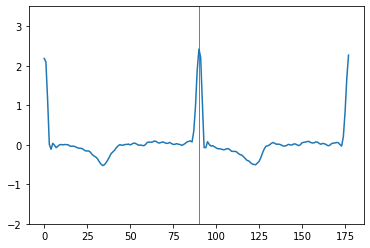

In [ ]:
#---------------------------] Plotted using varible length (prev_R to next_R peak)
sgv,pkv = sel_binfo.get_signal_data_var(bi)
plt.figure('variable_R_2_R')
plt.ylim(-2,3.5)
print('signal length = ', sgv.shape, ' peak at ',pkv)
plt.plot(sgv)
plt.vlines(pkv,-2,3.5, linewidth=0.5)

### [ fixed length in seconds ]

signal length =  (385,)  peak at  192


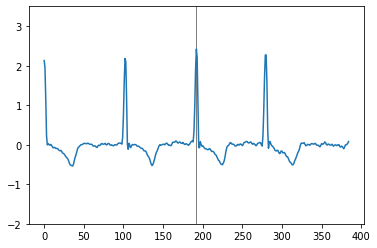

In [ ]:
#------------------------------] Plotted using fixed length (in seconds) on either side of R peak
sgf,pkf = sel_binfo.get_signal_data_fix(bi,1.5,1.5)
plt.figure('fixed_len_seconds')
plt.ylim(-2,3.5)
print('signal length = ', sgf.shape, ' peak at ',pkf)
plt.plot(sgf)
plt.vlines(pkf,-2,3.5, linewidth=0.5)


### [ resampled ]

signal length =  (256,)  peak at  127.66753246753247


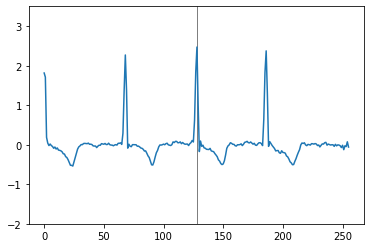

In [ ]:
#------------------------------] Plotted Resampled signal and peak location, 
# use sgf,pkf or sgv,pkv
sgr,pkr = sgf,pkf
resample_length = 2*BASIC_SRATE

sg1 = scsig.resample(sgr,resample_length)
pk1 = pkr*( len(sg1)/(len(sgr) ))
plt.figure('resampled')
plt.ylim(-2,3.5)
print('signal length = ', sg1.shape, ' peak at ',pk1)
plt.plot(sg1)
plt.vlines(pk1,-2,3.5, linewidth=0.5)


# [ REMOVE temp data types ]

In [ ]:
working_db = all_db


#data_types_remove = ['S','N','V','F','REP_300','REP_1800']
data_types_remove = ['REP_1800_exp_V_clf'] 
from_directory = global_tempdir
# Example -  g_REP_II_POSTFIX = 'REP_xxx' (REP_300, REP_1800), g_CLASS_II_POSTFIX = 'S', 'V' ,'F', 'N'
# Fixed data_types = g_BEAT_POSTFIX, g_NBEAT_POSTFIX = 'BEAT', 'NBEAT' g_SIG_II_POSTFIX = 'SIG_II' 
# for fixed data types use from_directory = sel_rec.db.dir_npy
total_removed = 0
verbos = True
for idb in working_db.keys():
    sel_db = working_db[idb]
    #if idb != 'mitdb':
    #    continue
    for irec in sel_db.recs:
        #if irec != '208':
        #    continue
        sel_rec = sel_db.get_record(irec)

        for rem_dt in data_types_remove:
            total_removed+=sel_rec.del_data_temp(rem_dt, from_directory, verbos)

print('\nTotal Files Removed = ', total_removed)

Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/105_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/220_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/203_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/117_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/233_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/122_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/100_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/103_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/123_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp/202_REP_1800_exp_V_clf.npy
Removing: /content/drive/My Drive/Masters/workdir/ecg_data/d